In [15]:
from datasets import load_dataset
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [16]:
model_mbart = 'facebook/mbart-large-50-one-to-many-mmt'

from transformers import MBart50TokenizerFast
tokenizer = MBart50TokenizerFast.from_pretrained(model_mbart, src_lang="en_XX", tgt_lang="id_ID")

In [17]:
def normalize_text(text):
    text = text.lower()  # Lowercase
    # text = re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters (except whitespace)
    # text = re.sub(r"\s+", " ", text)  # Replace excess whitespace with single space
    return text

source_lang = "en"
target_lang = "id"
def preprocess(data):
  inputs = [normalize_text(dt[source_lang]) for dt in data["translation"]]
  targets = [normalize_text(dt[target_lang]) for dt in data["translation"]]
  model_inputs = tokenizer(inputs, truncation=True)

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(targets, truncation=True)
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

tokenized_datasets = raw_datasets.map(preprocess, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [18]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)

In [19]:
from transformers import MBartForConditionalGeneration, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, Seq2SeqTrainer, EarlyStoppingCallback
model = MBartForConditionalGeneration.from_pretrained(model_mbart)
model = model.cuda()

In [20]:
# Freeze all layers except the decoder's last layers (adjust as needed)
count = 0
for param in model.get_encoder().parameters():
    param.requires_grad = False
    count+=1

print(f"freezes {count} layers")

freezes 198 layers


In [21]:
args = Seq2SeqTrainingArguments(
   f"mbart-large-50-one-to-many-mmt-finetuned-en-to-id",
   evaluation_strategy = "epoch",
   save_strategy= "epoch",
   learning_rate=1e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   weight_decay=0.01,
   save_total_limit=10,
   num_train_epochs=10,
   predict_with_generate=True,
   load_best_model_at_end= True,
   gradient_accumulation_steps=2,
)

In [22]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [23]:
import numpy as np
import evaluate
metric = evaluate.load("sacrebleu")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred!= tokenizer.pad_token_id) for pred in preds]
    result = {'bleu' : result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
trainer = Seq2SeqTrainer(
   model,
   args,
   train_dataset=small_train_dataset,
   eval_dataset=small_eval_dataset,
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
   # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

  0%|          | 0/156250 [00:00<?, ?it/s]

{'loss': 2.0932, 'grad_norm': 1.995510458946228, 'learning_rate': 9.968000000000002e-06, 'epoch': 0.03}
{'loss': 1.8822, 'grad_norm': 2.1881120204925537, 'learning_rate': 9.936000000000001e-06, 'epoch': 0.06}
{'loss': 1.8093, 'grad_norm': 1.9997444152832031, 'learning_rate': 9.904e-06, 'epoch': 0.1}
{'loss': 1.7906, 'grad_norm': 2.1327805519104004, 'learning_rate': 9.872e-06, 'epoch': 0.13}
{'loss': 1.7671, 'grad_norm': 1.959426999092102, 'learning_rate': 9.84e-06, 'epoch': 0.16}
{'loss': 1.7471, 'grad_norm': 2.079005479812622, 'learning_rate': 9.808000000000002e-06, 'epoch': 0.19}
{'loss': 1.7261, 'grad_norm': 2.305130958557129, 'learning_rate': 9.776000000000001e-06, 'epoch': 0.22}
{'loss': 1.7249, 'grad_norm': 2.382805109024048, 'learning_rate': 9.744000000000002e-06, 'epoch': 0.26}
{'loss': 1.6859, 'grad_norm': 1.887473225593567, 'learning_rate': 9.712e-06, 'epoch': 0.29}
{'loss': 1.6841, 'grad_norm': 2.389049768447876, 'learning_rate': 9.68e-06, 'epoch': 0.32}
{'loss': 1.6544, 'gr

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5810096263885498, 'eval_bleu': 29.6097, 'eval_gen_len': 12.725, 'eval_meteor': 0.5409, 'eval_runtime': 86.9931, 'eval_samples_per_second': 22.99, 'eval_steps_per_second': 1.437, 'epoch': 1.0}
{'loss': 1.5077, 'grad_norm': 2.0856218338012695, 'learning_rate': 8.976e-06, 'epoch': 1.02}
{'loss': 1.5085, 'grad_norm': 2.0429160594940186, 'learning_rate': 8.944000000000001e-06, 'epoch': 1.06}
{'loss': 1.5218, 'grad_norm': 2.0496230125427246, 'learning_rate': 8.912e-06, 'epoch': 1.09}
{'loss': 1.5204, 'grad_norm': 2.0138025283813477, 'learning_rate': 8.880000000000001e-06, 'epoch': 1.12}
{'loss': 1.5131, 'grad_norm': 2.448211193084717, 'learning_rate': 8.848e-06, 'epoch': 1.15}
{'loss': 1.49, 'grad_norm': 2.2810652256011963, 'learning_rate': 8.816000000000002e-06, 'epoch': 1.18}
{'loss': 1.503, 'grad_norm': 2.1556758880615234, 'learning_rate': 8.784000000000001e-06, 'epoch': 1.22}
{'loss': 1.507, 'grad_norm': 1.9604134559631348, 'learning_rate': 8.752e-06, 'epoch': 1.25}
{'los

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5280154943466187, 'eval_bleu': 30.1763, 'eval_gen_len': 12.753, 'eval_meteor': 0.545, 'eval_runtime': 87.4432, 'eval_samples_per_second': 22.872, 'eval_steps_per_second': 1.429, 'epoch': 2.0}
{'loss': 1.4431, 'grad_norm': 1.867213249206543, 'learning_rate': 7.984e-06, 'epoch': 2.02}
{'loss': 1.4144, 'grad_norm': 2.484874963760376, 'learning_rate': 7.952000000000001e-06, 'epoch': 2.05}
{'loss': 1.4027, 'grad_norm': 1.9950332641601562, 'learning_rate': 7.92e-06, 'epoch': 2.08}
{'loss': 1.3929, 'grad_norm': 2.5829734802246094, 'learning_rate': 7.888e-06, 'epoch': 2.11}
{'loss': 1.4183, 'grad_norm': 1.7890127897262573, 'learning_rate': 7.856e-06, 'epoch': 2.14}
{'loss': 1.4088, 'grad_norm': 1.9926788806915283, 'learning_rate': 7.824e-06, 'epoch': 2.18}
{'loss': 1.4059, 'grad_norm': 2.103989601135254, 'learning_rate': 7.792000000000001e-06, 'epoch': 2.21}
{'loss': 1.4232, 'grad_norm': 2.2637174129486084, 'learning_rate': 7.76e-06, 'epoch': 2.24}
{'loss': 1.4018, 'grad_norm':

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5055866241455078, 'eval_bleu': 30.3674, 'eval_gen_len': 12.7375, 'eval_meteor': 0.5492, 'eval_runtime': 84.1865, 'eval_samples_per_second': 23.757, 'eval_steps_per_second': 1.485, 'epoch': 3.0}
{'loss': 1.3886, 'grad_norm': 2.385016918182373, 'learning_rate': 6.992000000000001e-06, 'epoch': 3.01}
{'loss': 1.321, 'grad_norm': 2.4059367179870605, 'learning_rate': 6.96e-06, 'epoch': 3.04}
{'loss': 1.3505, 'grad_norm': 2.4526278972625732, 'learning_rate': 6.928e-06, 'epoch': 3.07}
{'loss': 1.339, 'grad_norm': 2.375472068786621, 'learning_rate': 6.8960000000000006e-06, 'epoch': 3.1}
{'loss': 1.3419, 'grad_norm': 2.313115358352661, 'learning_rate': 6.864000000000001e-06, 'epoch': 3.14}
{'loss': 1.3529, 'grad_norm': 2.515657663345337, 'learning_rate': 6.832000000000001e-06, 'epoch': 3.17}
{'loss': 1.3465, 'grad_norm': 2.821432590484619, 'learning_rate': 6.800000000000001e-06, 'epoch': 3.2}
{'loss': 1.3595, 'grad_norm': 2.466726779937744, 'learning_rate': 6.768e-06, 'epoch': 3.

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4970455169677734, 'eval_bleu': 30.4685, 'eval_gen_len': 12.8535, 'eval_meteor': 0.5489, 'eval_runtime': 83.1542, 'eval_samples_per_second': 24.052, 'eval_steps_per_second': 1.503, 'epoch': 4.0}
{'loss': 1.2832, 'grad_norm': 2.0233042240142822, 'learning_rate': 5.968e-06, 'epoch': 4.03}
{'loss': 1.2945, 'grad_norm': 2.7527267932891846, 'learning_rate': 5.9360000000000004e-06, 'epoch': 4.06}
{'loss': 1.2993, 'grad_norm': 2.4383280277252197, 'learning_rate': 5.9040000000000006e-06, 'epoch': 4.1}
{'loss': 1.2866, 'grad_norm': 2.199228286743164, 'learning_rate': 5.872000000000001e-06, 'epoch': 4.13}
{'loss': 1.289, 'grad_norm': 1.8337273597717285, 'learning_rate': 5.84e-06, 'epoch': 4.16}
{'loss': 1.3268, 'grad_norm': 2.339428186416626, 'learning_rate': 5.808e-06, 'epoch': 4.19}
{'loss': 1.2965, 'grad_norm': 2.4473764896392822, 'learning_rate': 5.776e-06, 'epoch': 4.22}
{'loss': 1.3023, 'grad_norm': 2.380563259124756, 'learning_rate': 5.744e-06, 'epoch': 4.26}
{'loss': 1.301

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4919929504394531, 'eval_bleu': 30.9056, 'eval_gen_len': 12.7715, 'eval_meteor': 0.5503, 'eval_runtime': 85.0297, 'eval_samples_per_second': 23.521, 'eval_steps_per_second': 1.47, 'epoch': 5.0}
{'loss': 1.2828, 'grad_norm': 2.6238529682159424, 'learning_rate': 4.976e-06, 'epoch': 5.02}
{'loss': 1.2576, 'grad_norm': 2.289655923843384, 'learning_rate': 4.9440000000000004e-06, 'epoch': 5.06}
{'loss': 1.2601, 'grad_norm': 2.4606547355651855, 'learning_rate': 4.9120000000000006e-06, 'epoch': 5.09}
{'loss': 1.2696, 'grad_norm': 2.5560834407806396, 'learning_rate': 4.880000000000001e-06, 'epoch': 5.12}
{'loss': 1.251, 'grad_norm': 2.643021583557129, 'learning_rate': 4.848000000000001e-06, 'epoch': 5.15}
{'loss': 1.2729, 'grad_norm': 2.5581166744232178, 'learning_rate': 4.816e-06, 'epoch': 5.18}
{'loss': 1.2397, 'grad_norm': 2.875054121017456, 'learning_rate': 4.784e-06, 'epoch': 5.22}
{'loss': 1.264, 'grad_norm': 3.2288320064544678, 'learning_rate': 4.752e-06, 'epoch': 5.25}
{'

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.492728352546692, 'eval_bleu': 30.6871, 'eval_gen_len': 12.707, 'eval_meteor': 0.5496, 'eval_runtime': 83.9094, 'eval_samples_per_second': 23.835, 'eval_steps_per_second': 1.49, 'epoch': 6.0}
{'loss': 1.2315, 'grad_norm': 2.5661368370056152, 'learning_rate': 3.984e-06, 'epoch': 6.02}
{'loss': 1.2446, 'grad_norm': 1.7944166660308838, 'learning_rate': 3.9520000000000004e-06, 'epoch': 6.05}
{'loss': 1.2289, 'grad_norm': 2.6093013286590576, 'learning_rate': 3.920000000000001e-06, 'epoch': 6.08}
{'loss': 1.2228, 'grad_norm': 2.4431025981903076, 'learning_rate': 3.888e-06, 'epoch': 6.11}
{'loss': 1.2172, 'grad_norm': 2.2909011840820312, 'learning_rate': 3.856e-06, 'epoch': 6.14}
{'loss': 1.2252, 'grad_norm': 2.5192747116088867, 'learning_rate': 3.824e-06, 'epoch': 6.18}
{'loss': 1.2084, 'grad_norm': 2.655266046524048, 'learning_rate': 3.7920000000000003e-06, 'epoch': 6.21}
{'loss': 1.2437, 'grad_norm': 2.574491024017334, 'learning_rate': 3.7600000000000004e-06, 'epoch': 6.24}


  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4924736022949219, 'eval_bleu': 30.8259, 'eval_gen_len': 12.768, 'eval_meteor': 0.5504, 'eval_runtime': 83.6054, 'eval_samples_per_second': 23.922, 'eval_steps_per_second': 1.495, 'epoch': 7.0}
{'loss': 1.2076, 'grad_norm': 2.239403009414673, 'learning_rate': 2.9920000000000003e-06, 'epoch': 7.01}
{'loss': 1.2216, 'grad_norm': 3.0439767837524414, 'learning_rate': 2.96e-06, 'epoch': 7.04}
{'loss': 1.1849, 'grad_norm': 2.218668222427368, 'learning_rate': 2.928e-06, 'epoch': 7.07}
{'loss': 1.2388, 'grad_norm': 3.0939948558807373, 'learning_rate': 2.8960000000000003e-06, 'epoch': 7.1}
{'loss': 1.1976, 'grad_norm': 2.267374277114868, 'learning_rate': 2.864e-06, 'epoch': 7.14}
{'loss': 1.2014, 'grad_norm': 2.5116333961486816, 'learning_rate': 2.832e-06, 'epoch': 7.17}
{'loss': 1.2004, 'grad_norm': 2.584374189376831, 'learning_rate': 2.8000000000000003e-06, 'epoch': 7.2}
{'loss': 1.2016, 'grad_norm': 2.9012279510498047, 'learning_rate': 2.768e-06, 'epoch': 7.23}
{'loss': 1.191,

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4945107698440552, 'eval_bleu': 30.6909, 'eval_gen_len': 12.8155, 'eval_meteor': 0.5499, 'eval_runtime': 84.5226, 'eval_samples_per_second': 23.662, 'eval_steps_per_second': 1.479, 'epoch': 8.0}
{'loss': 1.1767, 'grad_norm': 4.066218852996826, 'learning_rate': 1.968e-06, 'epoch': 8.03}
{'loss': 1.1916, 'grad_norm': 2.7311322689056396, 'learning_rate': 1.936e-06, 'epoch': 8.06}
{'loss': 1.1732, 'grad_norm': 2.2790887355804443, 'learning_rate': 1.9040000000000003e-06, 'epoch': 8.1}
{'loss': 1.1898, 'grad_norm': 2.4508249759674072, 'learning_rate': 1.8720000000000002e-06, 'epoch': 8.13}
{'loss': 1.1869, 'grad_norm': 2.5034148693084717, 'learning_rate': 1.8400000000000002e-06, 'epoch': 8.16}
{'loss': 1.1781, 'grad_norm': 2.2172489166259766, 'learning_rate': 1.808e-06, 'epoch': 8.19}
{'loss': 1.203, 'grad_norm': 2.3358359336853027, 'learning_rate': 1.7760000000000002e-06, 'epoch': 8.22}
{'loss': 1.1962, 'grad_norm': 2.431669235229492, 'learning_rate': 1.7440000000000002e-06, 

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.4983900785446167, 'eval_bleu': 30.4868, 'eval_gen_len': 12.8125, 'eval_meteor': 0.5488, 'eval_runtime': 84.6846, 'eval_samples_per_second': 23.617, 'eval_steps_per_second': 1.476, 'epoch': 9.0}
{'loss': 1.1866, 'grad_norm': 2.5075790882110596, 'learning_rate': 9.76e-07, 'epoch': 9.02}
{'loss': 1.1579, 'grad_norm': 3.059342622756958, 'learning_rate': 9.440000000000001e-07, 'epoch': 9.06}
{'loss': 1.1835, 'grad_norm': 2.0841288566589355, 'learning_rate': 9.120000000000001e-07, 'epoch': 9.09}
{'loss': 1.1668, 'grad_norm': 2.1930131912231445, 'learning_rate': 8.8e-07, 'epoch': 9.12}
{'loss': 1.1749, 'grad_norm': 2.723914623260498, 'learning_rate': 8.480000000000001e-07, 'epoch': 9.15}
{'loss': 1.1646, 'grad_norm': 2.737731695175171, 'learning_rate': 8.160000000000001e-07, 'epoch': 9.18}
{'loss': 1.1493, 'grad_norm': 3.9622015953063965, 'learning_rate': 7.84e-07, 'epoch': 9.22}
{'loss': 1.1784, 'grad_norm': 2.4072537422180176, 'learning_rate': 7.520000000000001e-07, 'epoch':

  0%|          | 0/125 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


{'eval_loss': 1.5002484321594238, 'eval_bleu': 30.4624, 'eval_gen_len': 12.785, 'eval_meteor': 0.549, 'eval_runtime': 83.8204, 'eval_samples_per_second': 23.861, 'eval_steps_per_second': 1.491, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


{'train_runtime': 27850.4461, 'train_samples_per_second': 179.53, 'train_steps_per_second': 5.61, 'train_loss': 1.32764317265625, 'epoch': 10.0}


TrainOutput(global_step=156250, training_loss=1.32764317265625, metrics={'train_runtime': 27850.4461, 'train_samples_per_second': 179.53, 'train_steps_per_second': 5.61, 'total_flos': 3.063261629959373e+17, 'train_loss': 1.32764317265625, 'epoch': 10.0})

In [25]:
trainer.save_model('model/mbart-large-50-one-to-many-mmt-finetuned-en-to-id')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


In [26]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
bleu_log = log_history["eval_bleu"].dropna().to_list()
meteor_log = log_history["eval_meteor"].dropna().to_list()
eval_log = log_history["eval_loss"].dropna().to_list()

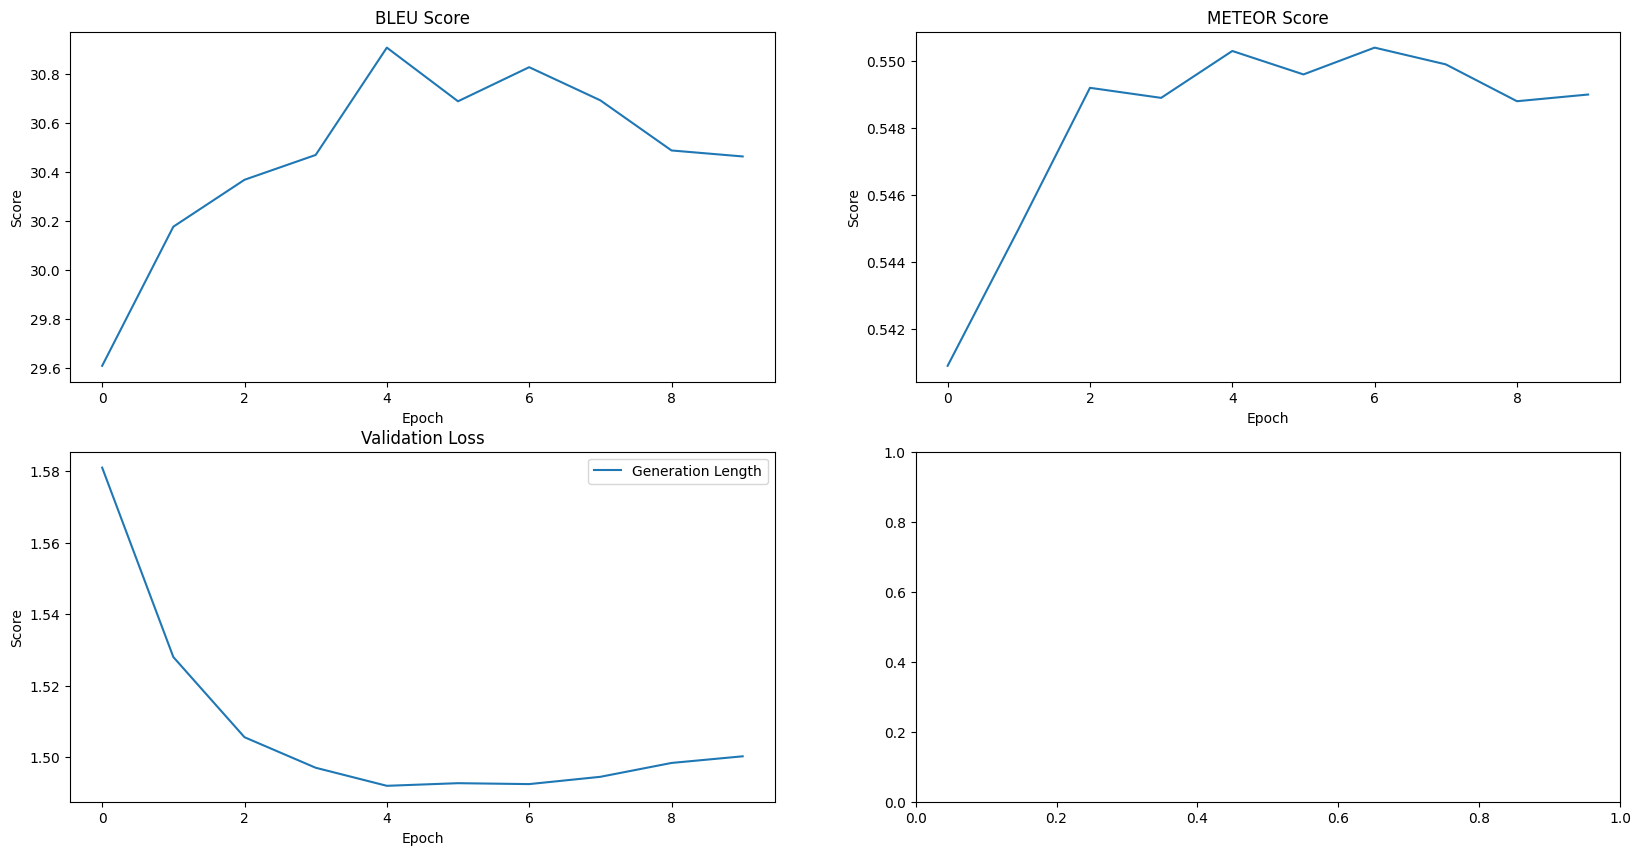

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Generation Length')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [28]:
import csv
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open('mBART.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)